# Accelerating Trading on GPU via RAPIDS

In [1]:
import cupy as cp
import cudf
import cuml
import glob
from tqdm import tqdm
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
PATH = "/kaggle/input/optiver-realized-volatility-prediction"


def load_data(mode, path="/kaggle/input/optiver-realized-volatility-prediction"):
    # mode = "train"/"test"
    file_name = f'{path}/{mode}.csv'
    return cudf.read_csv(file_name)

dev_df = load_data("train", path=PATH)
dev_df.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [3]:
SCALE = 100
dev_df["target"] = SCALE*dev_df["target"]

stock_ids = dev_df["stock_id"].unique()
len(stock_ids)

112

In [4]:
order_book_training = glob.glob(f'{PATH}/book_train.parquet/*/*')
order_book_test = glob.glob(f'{PATH}/book_test.parquet/*/*')

len(order_book_training), len(order_book_test)

(112, 1)

In [5]:
trades_training = glob.glob(f'{PATH}/trade_train.parquet/*/*')
trades_test = glob.glob(f'{PATH}/trade_test.parquet/*/*')

len(trades_training), len(trades_test) 

(112, 1)

## Using rapids-kaggle-utils for missing cuDF aggregation functions

In [6]:
%cd /kaggle/input/rapids-kaggle-utils/

/kaggle/input/rapids-kaggle-utils


In [7]:
import cu_utils.transform as cutran



def log_diff(df, in_col, null_val):
    df["logx"] = df[in_col].log()
    df["logx_shifted"] = (df[["time_id", "logx"]].groupby("time_id", method='cudf')
                             .apply_grouped(cutran.get_cu_shift_transform(shift_by=1, null_val=null_val),
                                            incols={"logx": 'x'},
                                            outcols=dict(y_out=cp.float32),
                                            tpb=32)["y_out"])
    df["keep_row"] = df[f"logx_shifted"] != null_val
    return df["logx"] - df["logx_shifted"]

def realized_vol(log_return):
    return cp.sqrt((log_return*log_return).sum())

def extract_raw_book_features(df, null_val=-9999):
    df['wap1']=(df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['wap2']=(df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])     
    df['wap3']=(df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['wap4']=(df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])                                                                                  
    for n in [1,2,3,4]:
        df[f"log_return{n}"] = log_diff(df, in_col=f"wap{n}", null_val=null_val)
        df[f"realized_vol{n}"] = df[f"log_return{n}"]**2    
    df['wap_balance'] = df['wap1'] - df['wap2']
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread1'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    df = df[df["keep_row"]]
    return df


def extract_raw_trade_features(df, null_val=-9999):
    df["realized_vol_trade"] = log_diff(df, in_col=f"price", null_val=null_val)**2
    df["amount"] = df['price']*df['size']
    df = df[df["keep_row"]]
    return df


def agg(df, feature_dict):
    agg_df = df.groupby("time_id").agg(feature_dict).reset_index()
    def f(x):
        if x[1] == "":
            return x[0]
        return x[0] + "_" + x[1]
    
    agg_df.columns = [f(x) for x in agg_df.columns]
    col_vol=[col for col in agg_df.columns if 'realized_vol' in col and ('mean' in col or 'sum' in col)]
    agg_df[col_vol]=agg_df[col_vol].sqrt()
    return agg_df    


def extract_book_stats(df):
    feature_dict = {
        'wap1': ["sum", "std"],
        'wap2': ["sum", "std"],
        'wap3': ["sum", "std"],
        'wap4': ["sum", "std"],
        'realized_vol1':["mean"],
        'realized_vol2':["mean"],
        'realized_vol3':["mean"],
        'realized_vol4':["mean"],
        'price_spread': ["sum", "max"],
        'price_spread1': ["sum", "max"],
        'wap_balance': ["sum", "max"],
        'bid_spread': ["sum", "max"],
        'ask_spread': ["sum", "max"],
        'total_volume': ["sum", "max"],
        'volume_imbalance': ["sum", "max"],
        "bid_ask_spread":["sum", "max"],
    }
    
    return agg(df, feature_dict)
    
def extract_book_stats_time(df):
    feature_dict = {
        'realized_vol1':["mean"],
        'realized_vol2':["mean"],
        'realized_vol3':["mean"],
        'realized_vol4':["mean"],
    }
    
    return agg(df, feature_dict)
    
    
def extract_trade_stats(df):
    feature_dict = {
        'realized_vol_trade': ["mean"],
        'seconds_in_bucket':["nunique"],
        'size': ["sum",'max'],
        'order_count': ["sum",'max'],
        'amount':['sum','max'],
    }
    return agg(df, feature_dict)

def extract_trade_stats_time(df):
    feature_dict = {
        'realized_vol_trade': ["mean"],
        'seconds_in_bucket':["nunique"],
        'size': ["sum"],
        'amount':['sum'],
        'order_count': ["sum"],
    }
    return agg(df, feature_dict)

def time_constraint_fe(df, stats_df, intervel_sec, fe_function, cols):
    sub_df = df[(df["seconds_in_bucket"] >= intervel_sec[0])&(df["seconds_in_bucket"] <= intervel_sec[1])].reset_index(drop=True)
    if sub_df.shape[0] > 0:
        sub_stats = fe_function(sub_df)
    else:
        sub_stats = cudf.DataFrame(columns=cols)#
    return stats_df.merge(sub_stats, on="time_id", how="left", suffixes=('', f'_{intervel_sec[0]}_{intervel_sec[1]}'))    
    

def feature_engineering(book_path, trade_path):
    book_df = cudf.read_parquet(book_path)
    book_df = extract_raw_book_features(book_df)
    book_stats = extract_book_stats(book_df)
    #book_cols = book_stats.columns
    book_cols_time=['realized_vol1_mean','realized_vol2_mean','realized_vol3_mean','realized_vol4_mean']+['time_id']
    
    trade_df = cudf.read_parquet(trade_path)
    trade_df = extract_raw_trade_features(trade_df)
    trade_stats = extract_trade_stats(trade_df)
    #trade_cols = trade_stats.columns
    trade_cols_time=['realized_vol_trade_mean','seconds_in_bucket_nunique','size_sum','order_count_sum','amount_sum']+['time_id']
    for intervel_sec in [[0, 240],[240, 480],[360, 600],[200,600],[300,600],[400,600]]:
        book_stats = time_constraint_fe(book_df, book_stats, intervel_sec, extract_book_stats_time, book_cols_time) 
        trade_stats = time_constraint_fe(trade_df, trade_stats, intervel_sec, extract_trade_stats_time, trade_cols_time) 
    
    return book_stats.merge(trade_stats, on="time_id", how="left")


def process_data(order_book_paths, trade_paths, stock_ids):
    stock_dfs = []
    for book_path, trade_path in tqdm(list(zip(order_book_paths, trade_paths))):
        stock_id = int(book_path.split("=")[1].split("/")[0])

        df = feature_engineering(book_path, trade_path)
        df["stock_id"] = stock_id
        stock_dfs.append(df)
    return cudf.concat(stock_dfs)

In [8]:
train = process_data(order_book_training, trades_training, stock_ids)
test = process_data(order_book_test, trades_test, stock_ids)
train.shape, test.shape

100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


((428932, 92), (1, 92))

In [9]:
def stock_time_fe(df):
    cols = ['realized_vol1_mean', 'realized_vol2_mean', 
            'realized_vol1_mean_200_600', 'realized_vol2_mean_200_600',
            'realized_vol1_mean_300_600', 'realized_vol2_mean_300_600', 
            'realized_vol1_mean_400_600', 'realized_vol2_mean_400_600',
           ]
    tmp_df=df[~df["is_test"]]
    for agg_col in ["stock_id", "time_id"]:
        for agg_func in ["mean", "max", "std", "min"]:
            agg_df = tmp_df.groupby(agg_col)[cols].agg(agg_func)
            agg_df.columns = [f"{agg_col}_{agg_func}_{col}" for col in agg_df.columns]
            df = df.merge(agg_df.reset_index(), on=agg_col, how="left")
    
    return df

train["is_test"] = False
test["is_test"] = True
all_df = train.append(test).reset_index(drop=True)

all_df = stock_time_fe(all_df)
train = all_df[~all_df["is_test"]]
test = all_df[all_df["is_test"]].to_pandas()


In [10]:
train = dev_df.merge(train, on=["stock_id", "time_id"], how="left").to_pandas()

num_features = [col for col in list(train.columns)
            if col not in {"stock_id", "time_id", "target", "is_test"}]
len(num_features)

154

In [11]:
# replace by order sum (tau)
train['size_tau'] = np.sqrt( 1/ train['seconds_in_bucket_nunique'] )
test['size_tau'] = np.sqrt( 1/ test['seconds_in_bucket_nunique'] )
#train['size_tau_500'] = np.sqrt( 1/ train['seconds_in_bucket_count_500'] )
#test['size_tau_500'] = np.sqrt( 1/ test['seconds_in_bucket_count_500'] )
train['size_tau_400'] = np.sqrt( 1/ train['seconds_in_bucket_nunique_400_600'] )
test['size_tau_400'] = np.sqrt( 1/ test['seconds_in_bucket_nunique_400_600'] )
train['size_tau_300'] = np.sqrt( 1/ train['seconds_in_bucket_nunique_300_600'] )
test['size_tau_300'] = np.sqrt( 1/ test['seconds_in_bucket_nunique_300_600'] )
train['size_tau_200'] = np.sqrt( 1/ train['seconds_in_bucket_nunique_200_600'] )
test['size_tau_200'] = np.sqrt( 1/ test['seconds_in_bucket_nunique_200_600'] )
#train['size_tau_100'] = np.sqrt( 1/ train['seconds_in_bucket_count_100'] )
#test['size_tau_100'] = np.sqrt( 1/ test['seconds_in_bucket_count_100'] )

In [12]:
train['size_tau2'] = np.sqrt( 1/ train['order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['order_count_sum'] )
#train['size_tau2_500'] = np.sqrt( 0.16/ train['order_count_sum'] )
#test['size_tau2_500'] = np.sqrt( 0.16/ test['order_count_sum'] )
train['size_tau2_400'] = np.sqrt( 0.33/ train['order_count_sum'] )
test['size_tau2_400'] = np.sqrt( 0.33/ test['order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['order_count_sum'] )
train['size_tau2_200'] = np.sqrt( 0.66/ train['order_count_sum'] )
test['size_tau2_200'] = np.sqrt( 0.66/ test['order_count_sum'] )
#train['size_tau2_100'] = np.sqrt( 0.83/ train['order_count_sum'] )
#test['size_tau2_100'] = np.sqrt( 0.83/ test['order_count_sum'] )

# delta tau
train['size_tau2_d'] = train['size_tau2_400'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_400'] - test['size_tau2']

In [13]:
import pandas as pd
from sklearn.cluster import KMeans
# making agg features

train_p = dev_df.to_pandas()
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=5, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(5):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test.loc[test['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()

[1 4 1 0 1 1 0 1 2 0 4 4 1 1 1 1 1 0 1 1 1 4 1 1 3 1 1 1 3 1 3 1 1 1 3 3 1
 3 1 1 1 1 1 1 1 4 1 1 1 4 4 3 3 3 0 4 0 1 1 1 1 1 1 1 4 3 3 4 3 4 2 2 3 3
 4 1 0 4 3 3 3 1 1 1 4 0 3 3 1 4 1 1 1 1 1 1 1 3 1 4 1 1 1 4 1 1 1 4 1 4 1
 4]
[3, 6, 9, 18, 61, 63, 86, 97]
[0, 2, 4, 5, 7, 13, 14, 15, 16, 17, 19, 20, 21, 23, 26, 28, 29, 30, 32, 34, 35, 36, 39, 41, 42, 43, 44, 46, 47, 48, 51, 52, 53, 64, 66, 67, 68, 69, 70, 72, 85, 93, 94, 95, 100, 102, 103, 104, 105, 107, 108, 109, 111, 113, 114, 115, 118, 119, 120, 123, 125]
[8, 80, 81]
[27, 31, 33, 37, 38, 40, 58, 59, 60, 74, 75, 77, 82, 83, 88, 89, 90, 98, 99, 110]
[1, 10, 11, 22, 50, 55, 56, 62, 73, 76, 78, 84, 87, 96, 101, 112, 116, 122, 124, 126]


In [14]:
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

In [15]:
nnn = ['time_id',
     'realized_vol1_mean_0c1',
     'realized_vol1_mean_1c1',     
     'realized_vol1_mean_3c1',
     'realized_vol1_mean_4c1',     
     #'realized_vol1_sum_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     #'total_volume_sum_6c1',
     'size_sum_0c1',
     'size_sum_1c1', 
     'size_sum_3c1',
     'size_sum_4c1', 
     #'size_sum_6c1',
     'amount_sum_0c1',
     'amount_sum_1c1', 
     'amount_sum_3c1',
     'amount_sum_4c1', 
     #'amount_sum_6c1',
     'order_count_sum_0c1',
     'order_count_sum_1c1',
     'order_count_sum_3c1',
     'order_count_sum_4c1',
     #'order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     #'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     #'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     #'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     #'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     #'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     #'size_tau2_6c1',
      ] 
train = pd.merge(train,mat1[nnn],how='left',on='time_id')
test = pd.merge(test,mat2[nnn],how='left',on='time_id')

In [16]:
import gc
del mat1,mat2
gc.collect()

65086

## Train LGBM model on GPU

In [17]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate(train, test):
    # Hyperparammeters (just basic)
    seed0=2021
    params = {
        'objective': 'rmse',
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'max_bin':100,
        'min_data_in_leaf':500,
        'learning_rate': 0.05,
        'subsample': 0.72,
        'subsample_freq': 4,
        'feature_fraction': 0.5,
        'lambda_l1': 0.5,
        'lambda_l2': 1.0,
        'categorical_column':[0],
        'seed':seed0,
        'feature_fraction_seed': seed0,
        'bagging_seed': seed0,
        'drop_seed': seed0,
        'data_random_seed': seed0,
        "tree_learner": 'voting',
        'device': "gpu",
        'gpu_device_id':0,
        'verbose': -1}
    
    # Split features and target
    features=[col for col in train.columns if col not in ['row_id', 'target', 'time_id','is_test']]
    y = train['target']
    # Transform stock id to a numeric value
    #x['stock_id'] = x['stock_id'].astype(int)
    #x_test['stock_id'] = x_test['stock_id'].astype(int)
    
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 57, shuffle = True)
    # Iterate through each fold
    #stack_weight=[0.225,0.225,0.225,0.1,0.225]
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                        num_boost_round=1000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=50,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) * 0.2#stack_weight[fold]
        
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return test_predictions

Training fold 1
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.0429176	training's RMSPE: 0.19861	valid_1's rmse: 0.0454954	valid_1's RMSPE: 0.210634
[500]	training's rmse: 0.0407876	training's RMSPE: 0.188753	valid_1's rmse: 0.0443487	valid_1's RMSPE: 0.205325
[750]	training's rmse: 0.039464	training's RMSPE: 0.182628	valid_1's rmse: 0.0438219	valid_1's RMSPE: 0.202886
[1000]	training's rmse: 0.0384804	training's RMSPE: 0.178076	valid_1's rmse: 0.0435671	valid_1's RMSPE: 0.201706
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.0384804	training's RMSPE: 0.178076	valid_1's rmse: 0.0435671	valid_1's RMSPE: 0.201706
Training fold 2
Training until validation scores don't improve for 50 rounds
[250]	training's rmse: 0.0431208	training's RMSPE: 0.199392	valid_1's rmse: 0.0439497	valid_1's RMSPE: 0.204122
[500]	training's rmse: 0.0409284	training's RMSPE: 0.189254	valid_1's rmse: 0.0426603	valid_1's RMSPE: 0.198134
[750]	training

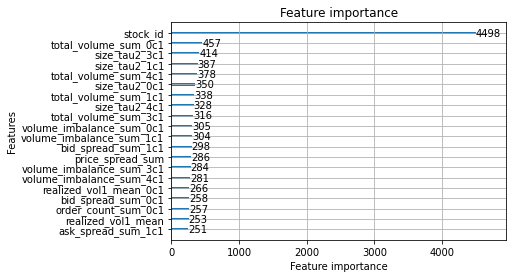

In [18]:
# Traing and evaluate
test_predictions = train_and_evaluate(train, test)
# Save test predictions
test["row_id"] = test["stock_id"].astype(str) + "-" + test["time_id"].astype(str) 
test["target"] = test_predictions/SCALE

In [19]:
gc.collect()

6300

In [20]:
train.shape

(428932, 211)

In [21]:
%cd /kaggle/working

/kaggle/working


In [22]:
sub_df = load_data("test", path=PATH).merge(cudf.from_pandas(test[["row_id", "target"]]), 
                                            on="row_id", how="left").fillna(0.0)

sub_df.to_csv("submission.csv", index=False, columns=["row_id", "target"])

In [23]:
sub_df.head(3)


,stock_id,time_id,row_id,target
0,0,4,0-4,0.001829
1,0,32,0-32,0.000000
2,0,34,0-34,0.000000
